In [1]:
# Import the QICK drivers and auxiliary libraries
from qick import *
from matplotlib import colors
from tqdm.notebook import tqdm
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
soc = QickSoc()
soccfg = soc
print(soccfg)


QICK configuration:

	Board: ZCU216

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	7 signal generator channels:
	0:	axis_signal_gen_v6 - tProc output 1, envelope memory 65536 samples
		DAC tile 2, ch 0, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	1:	axis_signal_gen_v6 - tProc output 2, envelope memory 65536 samples
		DAC tile 2, ch 1, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	2:	axis_signal_gen_v6 - tProc output 3, envelope memory 65536 samples
		DAC tile 2, ch 2, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	3:	axis_signal_gen_v6 - tProc output 4, envelope memory 65536 samples
		DAC tile 2, ch 3, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	4:	axis_signal_gen_v6 - tProc output 5, envelope memory 65536 samples
		DAC tile 3, ch 0, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	5:	axis_signal_gen_v6 - tProc output 6, envelope memory 65536 samples
		DAC tile 3, ch 1, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	6:	axis_signal_gen_v6 - tProc out

In [3]:
def plot_decimated(iq_list, soccfg, config, plot_iq=True):
#     fig, axs = plt.subplots(2,1,figsize=(10,10))
    t = soccfg.cycles2us(np.arange(len(iq_list[0][0])), ro_ch=config['ro_ch'])

    for ii, iq in enumerate(iq_list):
#         plot = axs[ii]
        if plot_iq:
            plt.plot(t, iq[0], label="I value, ADC %d"%(config['ro_ch']))
            plt.plot(t, iq[1], label="Q value, ADC %d"%(config['ro_ch']))
            plt.plot(t, np.abs(iq[0]+1j*iq[1]), label="mag, ADC %d"%(config['ro_ch']))
        else:
            plt.plot(t, iq[0], label="input value, ADC %d"%(config['ro_ch']))
        plt.ylabel("a.u.")
        plt.xlabel("Time [us]")
        plt.title("Averages = " + str(config["soft_avgs"]))
        plt.legend()


In [4]:
def noise(d_buf, verbose=True):
    diq = d_buf[:,0]+1j*d_buf[:,1]
    dmean = np.mean(diq)
    dmag = np.abs(dmean)
    if verbose: print("mean signal is %s (magnitude %f)" % (str(dmean), dmag))
    drotated = diq*np.exp(-1j*np.angle(dmean))
    magerr = np.real(drotated) # noise in the radial direction
    phaerr = np.imag(drotated) # noise in the radial direction
    
    rmsmag = np.std(magerr) # noise in the radial direction
    rmspha = np.std(phaerr) # noise in the azimuth direction
#     plt.hist(np.real(drotated))
    if verbose:
        print("amplitude noise: %f ADU, %f as a fraction of the signal (%f dB)" % (rmsmag, rmsmag/dmag, 20*np.log10(rmsmag/dmag)))
        print("phase noise: %f ADU, %f radians" % (rmspha, rmspha/dmag))
    return dmag, rmsmag, rmspha, magerr, phaerr


In [9]:
meas_cfg={"res_ch":2,
          'qubit_ch':0,
        "ro_ch":0,
        "pulse_gain":2000,
        "pulse_freq": 5500, # MHz, start value
        "nqz":2,
        'adc_trig_offset': 0.55,
        'length': 10,
        'readout_padding': -0.1,
        'relax_delay': 50
       }

  0%|          | 0/1000 [00:00<?, ?it/s]

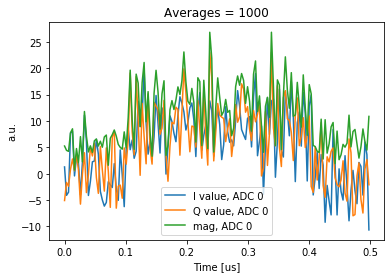

In [30]:
class SingleGenLoopbackProgram(AveragerProgram):
    def initialize(self):
        cfg = self.cfg
        style = cfg['style']
        
        for iCh, ch in enumerate([cfg["res_ch"]]):  # configure the readout lengths and downconversion frequencies
            length_gen = self.us2cycles(cfg['length'], gen_ch=ch)
            self.declare_gen(ch=ch, nqz=cfg['nqz'], ro_ch=cfg["ro_ch"])
            self.default_pulse_registers(ch=ch, 
                         freq=self.freq2reg(cfg["pulse_freq"],gen_ch=ch,ro_ch=cfg["ro_ch"]),
                         gain=cfg['pulse_gain'],
                         phase=0)
            if style == "const":
                self.set_pulse_registers(ch=ch, style=style, length=length_gen)
            elif style == "arb":
                self.add_gauss(ch=ch, name="measure", sigma=length_gen/5, length=length_gen)
                self.set_pulse_registers(ch=ch, style=style, waveform="measure")
            elif style == "flat_top":
                self.add_gauss(ch=ch, name="measure", sigma=length_gen/25, length=int(0.2*length_gen))
                self.set_pulse_registers(ch=ch, style=style, waveform="measure", length=int(0.8*length_gen))

        for iCh, ch in enumerate([cfg["ro_ch"]]):  # configure the readout lengths and downconversion frequencies
            length_ro = soccfg.us2cycles(cfg['length']+cfg['readout_padding'], ro_ch=ch)
            self.declare_readout(ch=ch, freq=cfg["pulse_freq"],
                                 length=length_ro,
                                 gen_ch=cfg["res_ch"])

        self.synci(200)  # give processor some time to configure pulses

    def body(self):
        self.measure(pulse_ch=self.cfg["res_ch"],
                     adcs=self.ro_chs,
                     pins=[0], 
                     adc_trig_offset=self.us2cycles(self.cfg["adc_trig_offset"]-0.5*self.cfg['readout_padding']),
                     wait=True,
                     syncdelay=self.us2cycles(self.cfg["relax_delay"]))
progconfig={
#     'style': 'arb',
    'style': 'const',
#     'style': 'flat_top',
    'length': 0.3, # [us]
    'reps': 1,
    'soft_avgs': 1000
       }
config={**meas_cfg,**progconfig} #combine configs
config['readout_padding'] = 0.2
prog = SingleGenLoopbackProgram(soccfg, config)
# print(prog)

iq_list = prog.acquire_decimated(soc, progress=True)
# Plot results.
plot_decimated(iq_list, soccfg, config, plot_iq=True)

In [32]:
progconfig={
    'style': 'const',
#     'style': 'flat_top',
    'length': 10, # [us]
    'reps': 1000
       }
config={**meas_cfg,**progconfig} #combine configs

# freqs = np.arange(5591, 5592.5, 0.05, dtype=float)
freqs = np.arange(5592.0, 5592.3, 0.02, dtype=float)

mags = np.zeros_like(freqs)
noises = np.zeros_like(freqs)
noise_phase = np.zeros_like(freqs)
# config['pulse_gain'] = 125
for i, f in tqdm(list(enumerate(freqs))):
    config['pulse_freq'] = f
#     config['nqz'] = 2
    
    prog = SingleGenLoopbackProgram(soccfg, config)
    res = prog.acquire(soc, load_pulses=True, progress=False, debug=False)
    
    d_buf = np.stack([prog.di_buf, prog.dq_buf], axis=-1)[0]/prog.ro_chs[0]['length']
    
    dmag, rmsmag, rmspha, magerr, phaerr = noise(d_buf, verbose=False)
    mags[i] = dmag
    noises[i] = rmsmag
    noise_phase[i] = rmspha
    
# plt.semilogy(soc.rfb_get_lo(gen_ch=config['res_ch']) - freqs, mags[:,0])
plt.semilogy(freqs, mags, label='gain')
plt.semilogy(freqs, noises, label='amplitude noise')
plt.semilogy(freqs, noise_phase, label='phase noise')
plt.legend()
plt.ylabel("amplitude [ADU]")

  0%|          | 0/16 [00:00<?, ?it/s]

streamer loop: got exception


RuntimeError: exception in readout loop

  0%|          | 0/16 [00:00<?, ?it/s]

Text(0, 0.5, 'amplitude [ADU]')

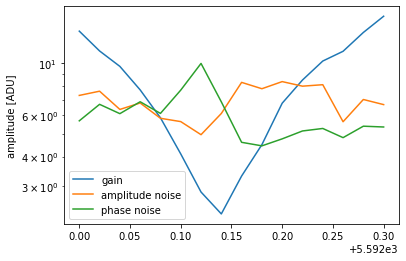

In [20]:
progconfig={
    'style': 'const',
#     'style': 'flat_top',
    'length': 10, # [us]
    'reps': 1000
       }
config={**meas_cfg,**progconfig} #combine configs

# freqs = np.arange(5591, 5592.5, 0.05, dtype=float)
freqs = np.arange(5592.0, 5592.3, 0.02, dtype=float)

mags = np.zeros_like(freqs)
noises = np.zeros_like(freqs)
noise_phase = np.zeros_like(freqs)
config['pulse_gain'] = 2000
for i, f in tqdm(list(enumerate(freqs))):
    config['pulse_freq'] = f
#     config['nqz'] = 2
    
    prog = SingleGenLoopbackProgram(soccfg, config)
    res = prog.acquire(soc, load_pulses=True, progress=False, debug=False)
    
    d_buf = np.stack([prog.di_buf, prog.dq_buf], axis=-1)[0]/prog.ro_chs[0]['length']
    
    dmag, rmsmag, rmspha, magerr, phaerr = noise(d_buf, verbose=False)
    mags[i] = dmag
    noises[i] = rmsmag
    noise_phase[i] = rmspha
    
# plt.semilogy(soc.rfb_get_lo(gen_ch=config['res_ch']) - freqs, mags[:,0])
plt.semilogy(freqs, mags, label='gain')
plt.semilogy(freqs, noises, label='amplitude noise')
plt.semilogy(freqs, noise_phase, label='phase noise')
plt.legend()
plt.ylabel("amplitude [ADU]")

In [145]:
progconfig={
    'style': 'const',
#     'style': 'flat_top',
    'length': 10, # [us]
    'reps': 1000
       }
config={**meas_cfg,**progconfig} #combine configs

# freqs = np.arange(5590.4, 5590.8, 0.02, dtype=float)
# gains = np.power(10,np.arange(3, 4.0, 0.1, dtype=float)).astype(int)
gains = np.power(10,np.arange(2.5, 3.5, 0.2, dtype=float)).astype(int)

print(freqs)
print(gains)
# gains = np.power(10,np.arange(1, 4.6, 0.5, dtype=float)).astype(int)

mags = np.zeros((len(freqs),len(gains)))
# noises = np.zeros_like(freqs)
# noise_phase = np.zeros_like(freqs)


for iG, g in tqdm(list(enumerate(gains))):
    for iF, f in enumerate(freqs):
        config['pulse_freq'] = f
        config['pulse_gain'] = g
                
#         config['nqz'] = 1

        prog = SingleGenLoopbackProgram(soccfg, config)
        res = prog.acquire(soc, load_pulses=True, progress=False, debug=False)

        d_buf = np.stack([prog.di_buf, prog.dq_buf], axis=-1)[0]/prog.ro_chs[0]['length']

        dmag, rmsmag, rmspha, magerr, phaerr = noise(d_buf, verbose=False)
        mags[iF,iG] = dmag
#         noises[i] = rmsmag
#         noise_phase[i] = rmspha
    
# plt.semilogy(soc.rfb_get_lo(gen_ch=config['res_ch']) - freqs, mags[:,0])
# plt.semilogy(freqs, mags, label='gain')
# plt.semilogy(freqs, noises, label='amplitude noise')
# plt.semilogy(freqs, noise_phase, label='phase noise')
# plt.legend()
# plt.ylabel("amplitude [ADU]")

[5592.   5592.02 5592.04 5592.06 5592.08 5592.1  5592.12 5592.14 5592.16
 5592.18 5592.2  5592.22 5592.24 5592.26 5592.28 5592.3 ]
[ 316  501  794 1258 1995]


  0%|          | 0/5 [00:00<?, ?it/s]

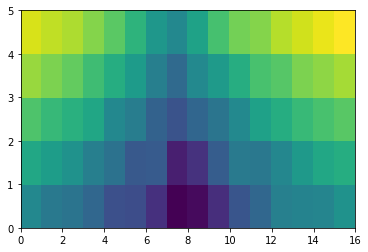

In [146]:
from matplotlib import colors

# print(mags.T)
scaledmags = mags.T

# scaledmags = mags.T/gains[:,np.newaxis]
# print(scaledmags)

plt.pcolormesh(scaledmags,norm=colors.LogNorm())

In [147]:
class PulseProbeSpectroscopyProgram(RAveragerProgram):
    def initialize(self):
        cfg=self.cfg
        
        length_gen = self.us2cycles(cfg['readout_length'], gen_ch=cfg["res_ch"])
        length_ro = self.us2cycles(cfg['readout_length']+cfg['readout_padding'], ro_ch=cfg["ro_ch"])

        self.declare_gen(ch=cfg["res_ch"], nqz=2) #Readout
        self.declare_gen(ch=cfg["qubit_ch"], nqz=2) #Qubit
        self.declare_readout(ch=cfg['ro_ch'], length=length_ro,
                             freq=cfg["f_res"], gen_ch=cfg["res_ch"])

        self.q_rp=self.ch_page(self.cfg["qubit_ch"]+1)     # get register page for qubit_ch
        self.r_freq=self.sreg(cfg["qubit_ch"]+1, "freq")   # get frequency register for qubit_ch    
        print(self.q_rp, self.r_freq)
        
        f_res=self.freq2reg(cfg["f_res"], gen_ch=cfg["res_ch"], ro_ch=cfg['ro_ch']) # conver f_res to dac register value

        self.f_start =self.freq2reg(cfg["start"], gen_ch=cfg["qubit_ch"])  # get start/step frequencies
        self.f_step =self.freq2reg(cfg["step"], gen_ch=cfg["qubit_ch"])

        # add qubit and readout pulses to respective channels
        self.set_pulse_registers(ch=cfg["qubit_ch"], style="const", freq=self.f_start, phase=0, gain=cfg["qubit_gain"], 
                                 length=cfg["probe_length"])
        self.set_pulse_registers(ch=cfg["res_ch"], style="const", freq=f_res, phase=cfg["res_phase"], gain=cfg["res_gain"], 
                                 length=length_gen)
        
        self.sync_all(self.us2cycles(1))
    
    def body(self):
        self.pulse(ch=self.cfg["qubit_ch"])  #play probe pulse
        self.sync_all(self.us2cycles(0.05)) # align channels and wait 50ns
#         self.sync_all(self.us2cycles(0.1)) # align channels and wait 50ns
        

        #trigger measurement, play measurement pulse, wait for qubit to relax
        self.measure(pulse_ch=self.cfg["res_ch"], 
             adcs=[self.cfg['ro_ch']],
             adc_trig_offset=self.us2cycles(self.cfg["adc_trig_offset"]-0.5*self.cfg['readout_padding']),
             wait=True,
             syncdelay=self.us2cycles(self.cfg["relax_delay"]))

    def update(self):
        self.mathi(self.q_rp, self.r_freq, self.r_freq, '+', self.f_step) # update frequency list index


1 13


  0%|          | 0/50 [00:00<?, ?it/s]

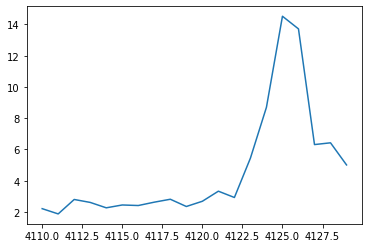

In [151]:
expt_cfg={"start":4110, "step":1, "expts":20, "reps": 20,"rounds":50,
          "probe_length":soccfg.us2cycles(2.0, gen_ch=0), "qubit_gain":10000,
          'readout_length': 4, #us
          'res_gain': 1000,
          'f_res': 5592.15,
          'res_phase':0
         }
config={**meas_cfg,**expt_cfg} #combine configs
# config['relax_delay'] = 1000

qspec=PulseProbeSpectroscopyProgram(soccfg, config)
# expt_pts, avgi, avgq = qspec.acquire(soc, threshold=readout_cfg["threshold"],load_pulses=True,progress=True, debug=False)
expt_pts, avgi, avgq = qspec.acquire(soc, load_pulses=True,progress=True, debug=False)
plt.plot(expt_pts,np.abs((avgi+1j*avgq)[0,0]))

# subplot(111,title="Qubit Spectroscopy", xlabel="Qubit Frequency (GHz)", ylabel="Qubit Population")
# plot(expt_pts, avgi[0][0],'o-')
# axvline(qubit_cfg["f_ge"]);

In [22]:
class LengthRabiProgram(AveragerProgram):
    def initialize(self):
        cfg=self.cfg
        
        length_gen = self.us2cycles(cfg['readout_length'], gen_ch=cfg["res_ch"])
        length_ro = self.us2cycles(cfg['readout_length']+cfg['readout_padding'], ro_ch=cfg["ro_ch"])

        self.declare_gen(ch=cfg["res_ch"], nqz=2) #Readout
        self.declare_gen(ch=cfg["qubit_ch"], nqz=2) #Qubit
        self.declare_readout(ch=cfg['ro_ch'], length=length_ro,
                             freq=cfg["f_res"], gen_ch=cfg["res_ch"])

#         self.q_rp=self.ch_page(self.cfg["qubit_ch"])     # get register page for qubit_ch
#         self.r_freq=self.sreg(cfg["qubit_ch"], "freq")   # get frequency register for qubit_ch    
        
        f_res=self.freq2reg(cfg["f_res"], gen_ch=cfg["res_ch"], ro_ch=cfg['ro_ch']) # conver f_res to dac register value
        f_ge=self.freq2reg(cfg["f_ge"], gen_ch=cfg["qubit_ch"])

#         self.f_start =self.freq2reg(cfg["start"], gen_ch=cfg["qubit_ch"])  # get start/step frequencies
#         self.f_step =self.freq2reg(cfg["step"], gen_ch=cfg["qubit_ch"])

        # add qubit and readout pulses to respective channels
        self.set_pulse_registers(ch=cfg["qubit_ch"], style="const", freq=f_ge, phase=0, gain=cfg["qubit_gain"], 
                                 length=cfg["pulse_length"])
        self.set_pulse_registers(ch=cfg["res_ch"], style="const", freq=f_res, phase=cfg["res_phase"], gain=cfg["res_gain"], 
                                 length=length_gen)
        
        self.sync_all(self.us2cycles(1))
    
    def body(self):
        self.pulse(ch=self.cfg["qubit_ch"])  #play probe pulse
        self.sync_all(self.us2cycles(0.05)) # align channels and wait 50ns

        #trigger measurement, play measurement pulse, wait for qubit to relax
        self.measure(pulse_ch=self.cfg["res_ch"], 
             adcs=[self.cfg['ro_ch']],
             adc_trig_offset=self.us2cycles(self.cfg["adc_trig_offset"]-0.5*self.cfg['readout_padding']),
             wait=True,
             syncdelay=self.us2cycles(self.cfg["relax_delay"]))

  0%|          | 0/200 [00:00<?, ?it/s]

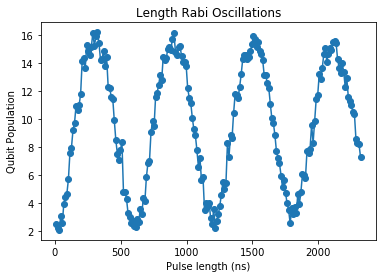

In [153]:
expt_cfg={
                 "qubit_gain":10000,
        "start":4, "step":5, "expts":200, "reps": 400,
          "probe_length":soccfg.us2cycles(2.0, gen_ch=0),
          'readout_length': 4, #us
          'res_gain': 1000,
          'f_res': 5592.13,
          'f_ge': 4126,
          'res_phase':0
         }
config={**meas_cfg,**expt_cfg} #combine configs

# qspec=PulseProbeSpectroscopyProgram(soccfg, config)
# # expt_pts, avgi, avgq = qspec.acquire(soc, threshold=readout_cfg["threshold"],load_pulses=True,progress=True, debug=False)
# expt_pts, avgi, avgq = qspec.acquire(soc, load_pulses=True,progress=True, debug=False)

# plt.plot(expt_pts,np.abs((avgi+1j*avgq)[0,0]))

expt_pts=[expt_cfg["start"] + ii*expt_cfg["step"] for ii in range(expt_cfg["expts"])]

results=[]
for length in tqdm(expt_pts):
    config["pulse_length"]=length

    rabi=LengthRabiProgram(soccfg, config)
#     avgi,avgq = rabi.acquire(soc, threshold=readout_cfg["threshold"], load_pulses=True, progress=False,debug=False)
    avgi,avgq = rabi.acquire(soc, load_pulses=True, progress=False,debug=False)
#     print((avgi+1j*avgq)[0][0])
    
    results.append(np.abs((avgi+1j*avgq)[0][0]))
    
subplot(111, title="Length Rabi Oscillations", xlabel="Pulse length (ns)", ylabel="Qubit Population")
plot(soccfg.cycles2us(np.array(expt_pts), gen_ch=0)*1000,results,'o-');

  0%|          | 0/200 [00:00<?, ?it/s]

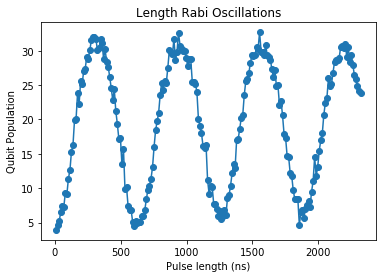

In [23]:
expt_cfg={
                 "qubit_gain":10000,
        "start":4, "step":5, "expts":200, "reps": 400,
          "probe_length":soccfg.us2cycles(2.0, gen_ch=0),
          'readout_length': 4, #us
          'res_gain': 2000,
          'f_res': 5592.14,
          'f_ge': 4126,
          'res_phase':0
         }
config={**meas_cfg,**expt_cfg} #combine configs

# qspec=PulseProbeSpectroscopyProgram(soccfg, config)
# # expt_pts, avgi, avgq = qspec.acquire(soc, threshold=readout_cfg["threshold"],load_pulses=True,progress=True, debug=False)
# expt_pts, avgi, avgq = qspec.acquire(soc, load_pulses=True,progress=True, debug=False)

# plt.plot(expt_pts,np.abs((avgi+1j*avgq)[0,0]))

expt_pts=[expt_cfg["start"] + ii*expt_cfg["step"] for ii in range(expt_cfg["expts"])]

results=[]
for length in tqdm(expt_pts):
    config["pulse_length"]=length

    rabi=LengthRabiProgram(soccfg, config)
#     avgi,avgq = rabi.acquire(soc, threshold=readout_cfg["threshold"], load_pulses=True, progress=False,debug=False)
    avgi,avgq = rabi.acquire(soc, load_pulses=True, progress=False,debug=False)
#     print((avgi+1j*avgq)[0][0])
    
    results.append(np.abs((avgi+1j*avgq)[0][0]))
    
subplot(111, title="Length Rabi Oscillations", xlabel="Pulse length (ns)", ylabel="Qubit Population")
plot(soccfg.cycles2us(np.array(expt_pts), gen_ch=0)*1000,results,'o-');

In [24]:
class T1Program(RAveragerProgram):
    def initialize(self):
        cfg=self.cfg
        
        self.q_rp=self.ch_page(cfg["qubit_ch"]+1)     # get register page for qubit_ch
        self.r_wait = 3
        self.regwi(self.q_rp, self.r_wait, cfg["start"])

        length_gen = self.us2cycles(cfg['readout_length'], gen_ch=cfg["res_ch"])
        length_ro = self.us2cycles(cfg['readout_length']+cfg['readout_padding'], ro_ch=cfg["ro_ch"])

        self.declare_gen(ch=cfg["res_ch"], nqz=2) #Readout
        self.declare_gen(ch=cfg["qubit_ch"], nqz=2) #Qubit
        self.declare_readout(ch=cfg['ro_ch'], length=length_ro,
                             freq=cfg["f_res"], gen_ch=cfg["res_ch"])

        f_res=self.freq2reg(cfg["f_res"], gen_ch=cfg["res_ch"], ro_ch=cfg['ro_ch']) # conver f_res to dac register value
        f_ge=self.freq2reg(cfg["f_ge"], gen_ch=cfg["qubit_ch"])

        self.f_start =self.freq2reg(cfg["start"], gen_ch=cfg["qubit_ch"])  # get start/step frequencies
        self.f_step =self.freq2reg(cfg["step"], gen_ch=cfg["qubit_ch"])

        # add qubit and readout pulses to respective channels
        self.set_pulse_registers(ch=cfg["qubit_ch"], style="const", freq=f_ge, phase=0, gain=cfg["qubit_gain"], 
                                 length=cfg["probe_length"])
        self.set_pulse_registers(ch=cfg["res_ch"], style="const", freq=f_res, phase=cfg["res_phase"], gain=cfg["res_gain"], 
                                 length=length_gen)
        
        self.sync_all(self.us2cycles(1))
    
    def body(self):
        self.pulse(ch=self.cfg["qubit_ch"])  #play probe pulse
        self.sync_all() # align channels and wait 50ns
        self.sync(self.q_rp,self.r_wait)

        #trigger measurement, play measurement pulse, wait for qubit to relax
        self.measure(pulse_ch=self.cfg["res_ch"], 
             adcs=[self.cfg['ro_ch']],
             adc_trig_offset=self.us2cycles(self.cfg["adc_trig_offset"]-0.5*self.cfg['readout_padding']),
             wait=True,
             syncdelay=self.us2cycles(self.cfg["relax_delay"]))

    def update(self):
        self.mathi(self.q_rp, self.r_wait, self.r_wait, '+', self.us2cycles(self.cfg["step"])) # update frequency list index

  0%|          | 0/60000 [00:00<?, ?it/s]

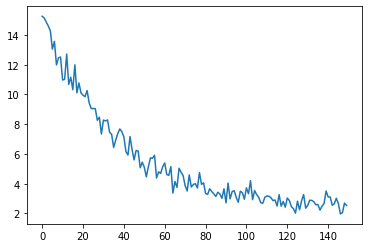

In [155]:
expt_cfg={"start":0, "step":1, "expts":150, "reps": 400,
          "probe_length":soccfg.us2cycles(0.260, gen_ch=0), "qubit_gain":10000,
          'readout_length': 4, #us
          'res_gain': 1000,
          'f_res': 5592.13,
          'res_phase':0,
          'f_ge': 4126,
         }

config={**meas_cfg,**expt_cfg} #combine configs

qspec=T1Program(soccfg, config)
# expt_pts, avgi, avgq = qspec.acquire(soc, threshold=readout_cfg["threshold"],load_pulses=True,progress=True, debug=False)
expt_pts, avgi, avgq = qspec.acquire(soc, load_pulses=True,progress=True, debug=False)

plt.plot(expt_pts,np.abs((avgi+1j*avgq)[0,0]))

  0%|          | 0/60000 [00:00<?, ?it/s]

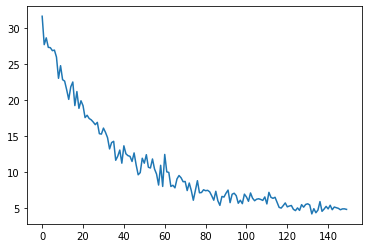

In [28]:
expt_cfg={"start":0, "step":1, "expts":150, "reps": 400,
          "probe_length":soccfg.us2cycles(0.260, gen_ch=0), "qubit_gain":10000,
          'readout_length': 4, #us
          'res_gain': 2000,
          'f_res': 5592.14,
          'res_phase':0,
          'f_ge': 4126,
         }

config={**meas_cfg,**expt_cfg} #combine configs

qspec=T1Program(soccfg, config)
# expt_pts, avgi, avgq = qspec.acquire(soc, threshold=readout_cfg["threshold"],load_pulses=True,progress=True, debug=False)
expt_pts, avgi, avgq = qspec.acquire(soc, load_pulses=True,progress=True, debug=False)

plt.plot(expt_pts,np.abs((avgi+1j*avgq)[0,0]))

In [156]:
class AmplitudeRabiProgram(RAveragerProgram):
    def initialize(self):
        cfg=self.cfg
        
        self.q_rp=self.ch_page(cfg["qubit_ch"]+1)     # get register page for qubit_ch
        self.r_gain=self.sreg(cfg["qubit_ch"]+1, "gain")   # get gain register for qubit_ch    

        length_gen = self.us2cycles(cfg['readout_length'], gen_ch=cfg["res_ch"])
        length_ro = self.us2cycles(cfg['readout_length']+cfg['readout_padding'], ro_ch=cfg["ro_ch"])

        self.declare_gen(ch=cfg["res_ch"], nqz=2) #Readout
        self.declare_gen(ch=cfg["qubit_ch"], nqz=2) #Qubit
        self.declare_readout(ch=cfg['ro_ch'], length=length_ro,
                             freq=cfg["f_res"], gen_ch=cfg["res_ch"])

        f_res=self.freq2reg(cfg["f_res"], gen_ch=cfg["res_ch"], ro_ch=cfg['ro_ch']) # conver f_res to dac register value
        f_ge=self.freq2reg(cfg["f_ge"], gen_ch=cfg["qubit_ch"])

        self.f_start =self.freq2reg(cfg["start"], gen_ch=cfg["qubit_ch"])  # get start/step frequencies
        self.f_step =self.freq2reg(cfg["step"], gen_ch=cfg["qubit_ch"])

        # add qubit and readout pulses to respective channels
        self.add_gauss(ch=cfg["qubit_ch"], name="qubit", sigma=cfg["sigma"], length=cfg["sigma"]*4)
        self.set_pulse_registers(ch=cfg["qubit_ch"], style="arb", freq=f_ge, phase=0, gain=cfg["start"],
                                 waveform="qubit")
        self.set_pulse_registers(ch=cfg["res_ch"], style="const", freq=f_res, phase=cfg["res_phase"], gain=cfg["res_gain"], 
                                 length=length_gen)
        
        self.sync_all(self.us2cycles(1))
    
    def body(self):
        self.pulse(ch=self.cfg["qubit_ch"])  #play probe pulse
        self.sync_all(self.us2cycles(0.05)) # align channels and wait 50ns
#         self.sync(self.q_rp,self.r_wait)

        #trigger measurement, play measurement pulse, wait for qubit to relax
        self.measure(pulse_ch=self.cfg["res_ch"], 
             adcs=[self.cfg['ro_ch']],
             adc_trig_offset=self.us2cycles(self.cfg["adc_trig_offset"]-0.5*self.cfg['readout_padding']),
             wait=True,
             syncdelay=self.us2cycles(self.cfg["relax_delay"]))

    def update(self):
            self.mathi(self.q_rp, self.r_gain, self.r_gain, '+', self.cfg["step"]) # update gain of the Gaussian pi pulse


In [29]:
expt_cfg={"start":0, "step":100, "expts":300, "reps": 400,
          'readout_length': 4, #us
          'res_gain': 1000,
          'f_res': 5592.13,
          'res_phase':0,
          'f_ge': 4126,
          "sigma":soccfg.us2cycles(0.300, gen_ch=0),
         }
config={**meas_cfg,**expt_cfg} #combine configs

qspec=AmplitudeRabiProgram(soccfg, config)
# expt_pts, avgi, avgq = qspec.acquire(soc, threshold=readout_cfg["threshold"],load_pulses=True,progress=True, debug=False)
expt_pts, avgi, avgq = qspec.acquire(soc, load_pulses=True,progress=True, debug=False)

plt.plot(expt_pts,np.abs((avgi+1j*avgq)[0,0]))

subplot(111, title= f"Amplitude Rabi, $\sigma={soccfg.cycles2us(config['sigma'], gen_ch=0)*1000}$ ns", xlabel="Gain", ylabel="Qubit Population" )
plot(expt_pts,np.abs((avgi+1j*avgq)[0,0]),'o-')

# axvline(qubit_cfg["pi_gain"])
# axvline(qubit_cfg["pi2_gain"]);

NameError: name 'AmplitudeRabiProgram' is not defined